In [128]:
import pandas as pd

# Load the CSV file into a DataFrame again
spy_data_q4 = pd.read_csv('/Users/eslifolkes/Downloads/SPY_OptionsChain_Q4_2022.csv')

# Display the first few rows of the dataset to inspect its structure
spy_data_q4.head()


,_QUOTE_UNIXTIME_,__QUOTE_READTIME_,__QUOTE_DATE_,__QUOTE_TIME_HOURS_,__UNDERLYING_LAST_,__EXPIRE_DATE_,__EXPIRE_UNIX_,__DTE_,__C_DELTA_,__C_GAMMA_,__C_VEGA_,__C_THETA_,__C_RHO_,__C_IV_,__C_VOLUME_,__C_LAST_,__C_SIZE_,__C_BID_,__C_ASK_,__STRIKE_,__P_BID_,__P_ASK_,__P_SIZE_,__P_LAST_,__P_DELTA_,__P_GAMMA_,__P_VEGA_,__P_THETA_,__P_RHO_,__P_IV_,__P_VOLUME_,__STRIKE_DISTANCE_,__STRIKE_DISTANCE_PCT_
0,1662062400,2022-09-01 16:00:00 UTC,2022-09-01,16,396.39,2022-09-12,1663012800,11.0,0.82658,0.01493,0.17974,-0.17103,0.07389,0.255350,3.000000,14.020000,50 x 70,17.610000,17.940000,380.0,1.250000,1.270000,3859 x 1966,1.470000,-0.14907,0.01455,0.16595,-0.16343,-0.01928,0.225560,165.000000,16.4,0.041
1,1662062400,2022-09-01 16:00:00 UTC,2022-09-01,16,396.39,2022-09-23,1663963200,22.0,0.01296,0.00173,0.03322,-0.01227,0.00274,0.196440,0.000000,0.120000,3758 x 4927,0.080000,0.090000,441.0,45.400000,46.530000,1 x 2,0.000000,-1.00000,0.00000,14.19923,0.00000,0.00000,-0.000030,,44.6,0.113
2,1662062400,2022-09-01 16:00:00 UTC,2022-09-01,16,396.39,2022-10-07,1665172800,36.0,0.04918,0.00437,0.12897,-0.03008,0.01929,0.185270,38.000000,0.410000,1054 x 669,0.460000,0.480000,436.0,40.570000,41.390000,5 x 5,0.000000,-0.95755,0.00372,0.10121,-0.05021,-0.42267,0.169860,,39.6,0.100
3,1662062400,2022-09-01 16:00:00 UTC,2022-09-01,16,396.39,2022-09-23,1663963200,22.0,0.00087,0.00007,0.00341,-0.00238,0.00013,0.331440,0.000000,0.010000,0 x 8325,0.010000,0.010000,510.0,114.340000,115.390000,50 x 2,0.000000,-1.00000,0.00000,12.91311,0.00000,0.00000,-0.000050,,113.6,0.287
4,1662062400,2022-09-01 16:00:00 UTC,2022-09-01,16,396.39,2022-09-19,1663617600,18.0,0.45244,0.02039,0.35363,-0.18057,0.08122,0.221260,139.000000,5.880000,311 x 150,6.510000,6.540000,398.0,8.970000,9.020000,150 x 209,10.020000,-0.55188,0.02112,0.35338,-0.23855,-0.11687,0.206530,13.000000,1.6,0.004


In [129]:
# Convert necessary columns to numeric data type
cols_to_convert = ['__C_GAMMA_', '__C_VOLUME_', '__P_GAMMA_', '__P_VOLUME_', '__UNDERLYING_LAST_']

for col in cols_to_convert:
    spy_data_q4[col] = pd.to_numeric(spy_data_q4[col], errors='coerce')

# Retry the gamma demand calculations for calls and puts
spy_data_q4['Call_Gamma_Demand'] = spy_data_q4['__C_GAMMA_'] * spy_data_q4['__UNDERLYING_LAST_'] * spy_data_q4['__C_VOLUME_']
spy_data_q4['Put_Gamma_Demand'] = spy_data_q4['__P_GAMMA_'] * spy_data_q4['__UNDERLYING_LAST_'] * spy_data_q4['__P_VOLUME_']

# Group by date and sum the gamma demand for calls and puts
grouped_gamma = spy_data_q4.groupby('__QUOTE_DATE_').agg({
    'Call_Gamma_Demand': 'sum',
    'Put_Gamma_Demand': 'sum',
    '__UNDERLYING_LAST_': 'mean'
}).reset_index()

# Calculate Gamma Imbalance
grouped_gamma['Gamma_Imbalance'] = grouped_gamma['Call_Gamma_Demand'] - abs(grouped_gamma['Put_Gamma_Demand'])
grouped_gamma['Gamma_Imbalance_Ratio'] = grouped_gamma['Gamma_Imbalance'] / (abs(grouped_gamma['Call_Gamma_Demand']) + abs(grouped_gamma['Put_Gamma_Demand']))

grouped_gamma.head()


,__QUOTE_DATE_,Call_Gamma_Demand,Put_Gamma_Demand,__UNDERLYING_LAST_,Gamma_Imbalance,Gamma_Imbalance_Ratio
0,2022-09-01,1.475819e+07,1.449640e+07,396.39,2.617816e+05,0.008948
1,2022-09-02,1.496247e+07,4.053428e+07,392.27,-2.557181e+07,-0.460780
2,2022-09-05,7.556919e+06,1.145296e+07,392.24,-3.896042e+06,-0.204948
3,2022-09-06,1.770994e+07,1.611098e+07,390.79,1.598959e+06,0.047277
4,2022-09-07,1.187152e+07,1.461930e+07,397.79,-2.747780e+06,-0.103726


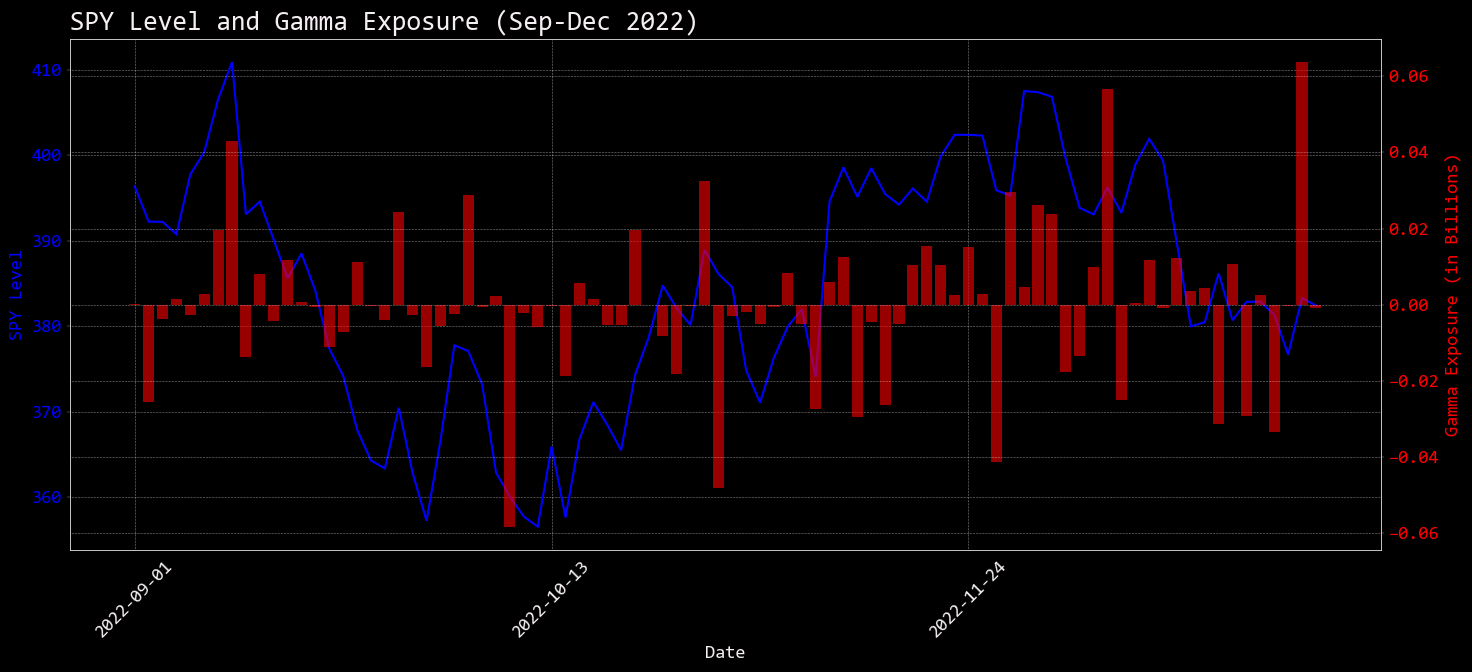

In [131]:
# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plot SPY level on the primary y-axis
ax1.plot(grouped_gamma['__QUOTE_DATE_'], grouped_gamma['__UNDERLYING_LAST_'], color='blue', label='SPY Level')
ax1.set_ylabel('SPY Level', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot daily Gamma Exposure (in billions) using bar chart on the secondary y-axis
ax2.bar(grouped_gamma['__QUOTE_DATE_'], grouped_gamma['Gamma_Imbalance'] / 1e9, color='red', alpha=0.6, label='Gamma Exposure (in Billions)')
ax2.set_ylabel('Gamma Exposure (in Billions)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Setting the title and x-axis label
ax1.set_title('SPY Level and Gamma Exposure (Sep-Dec 2022)')
ax1.set_xlabel('Date')

# Setting the x-axis to display monthly ticks
ax1.set_xticks(grouped_gamma['__QUOTE_DATE_'][::30])
ax1.set_xticklabels(grouped_gamma['__QUOTE_DATE_'][::30], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()



In [133]:
# Try converting the IV columns to float and capture any exceptions
def convert_to_float(val):
    try:
        return float(val)
    except:
        return np.nan

spy_data_q4['__C_IV_'] = spy_data_q4['__C_IV_'].apply(convert_to_float)
spy_data_q4['__P_IV_'] = spy_data_q4['__P_IV_'].apply(convert_to_float)

# Check for NaN values in the IV columns after conversion
nan_values_iv = {
    '__C_IV_': spy_data_q4['__C_IV_'].isna().sum(),
    '__P_IV_': spy_data_q4['__P_IV_'].isna().sum()
}

nan_values_iv


{'__C_IV_': 10801, '__P_IV_': 37306}

In [134]:
# Exclude rows with NaN values in the IV columns
spy_data_q4_cleaned = spy_data_q4.dropna(subset=['__C_IV_', '__P_IV_'])

# Retry the IV-weighted gamma exposure calculations
spy_data_q4_cleaned['Call_Gamma_IV_Weighted'] = spy_data_q4_cleaned['__C_GAMMA_'] * spy_data_q4_cleaned['__UNDERLYING_LAST_'] * spy_data_q4_cleaned['__C_IV_']
spy_data_q4_cleaned['Put_Gamma_IV_Weighted'] = spy_data_q4_cleaned['__P_GAMMA_'] * spy_data_q4_cleaned['__UNDERLYING_LAST_'] * spy_data_q4_cleaned['__P_IV_']

# Group by date and sum the IV-weighted gamma exposure for calls and puts
grouped_gamma_iv_cleaned = spy_data_q4_cleaned.groupby('__QUOTE_DATE_').agg({
    'Call_Gamma_IV_Weighted': 'sum',
    'Put_Gamma_IV_Weighted': 'sum',
    '__UNDERLYING_LAST_': 'mean'
}).reset_index()

# Calculate IV-weighted Gamma Imbalance
grouped_gamma_iv_cleaned['Gamma_IV_Imbalance'] = grouped_gamma_iv_cleaned['Call_Gamma_IV_Weighted'] - abs(grouped_gamma_iv_cleaned['Put_Gamma_IV_Weighted'])

grouped_gamma_iv_cleaned.head()


,__QUOTE_DATE_,Call_Gamma_IV_Weighted,Put_Gamma_IV_Weighted,__UNDERLYING_LAST_,Gamma_IV_Imbalance
0,2022-09-01,2083.437805,1855.998509,396.39,227.439296
1,2022-09-02,1569.254446,2597.104780,392.27,-1027.850334
2,2022-09-05,1813.471410,2532.453254,392.24,-718.981844
3,2022-09-06,2088.376055,2106.457050,390.79,-18.080994
4,2022-09-07,1888.643643,2002.587671,397.79,-113.944028


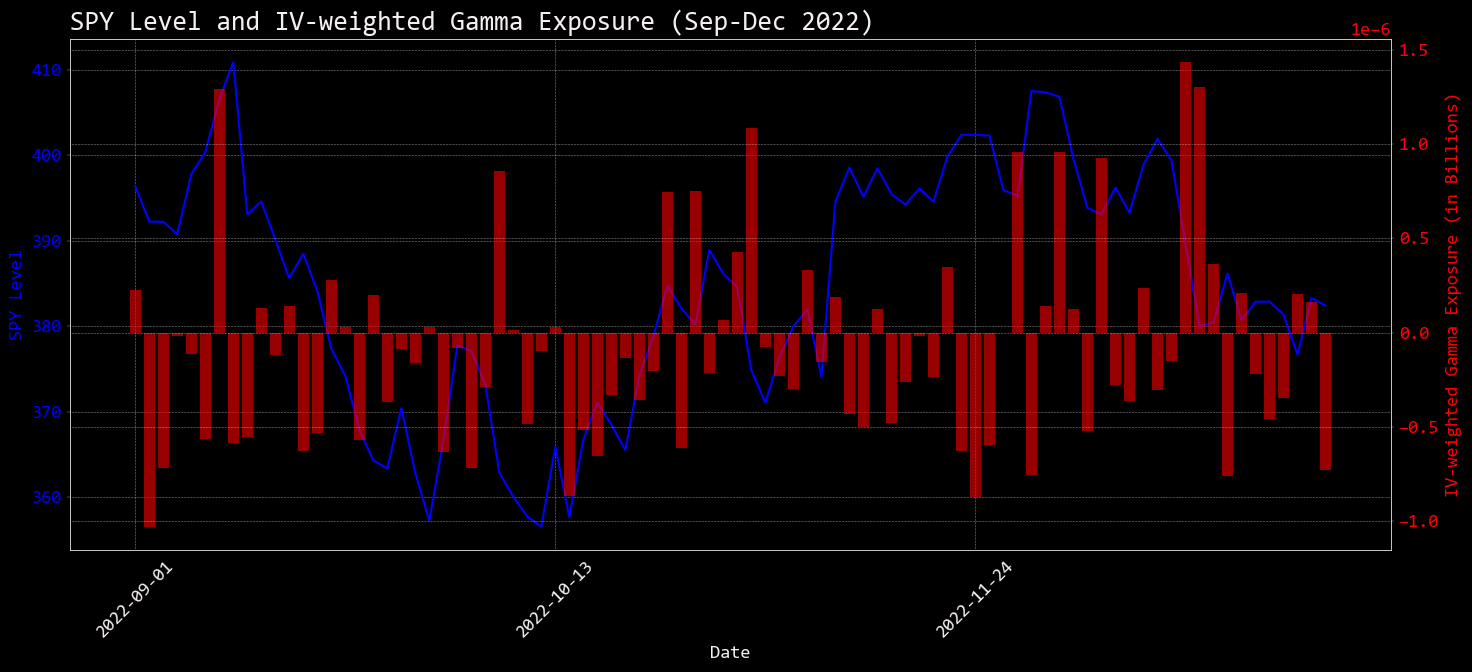

In [135]:
# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plot SPY level on the primary y-axis
ax1.plot(grouped_gamma_iv_cleaned['__QUOTE_DATE_'], grouped_gamma_iv_cleaned['__UNDERLYING_LAST_'], color='blue', label='SPY Level')
ax1.set_ylabel('SPY Level', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot IV-weighted Gamma Exposure using bar chart on the secondary y-axis
ax2.bar(grouped_gamma_iv_cleaned['__QUOTE_DATE_'], grouped_gamma_iv_cleaned['Gamma_IV_Imbalance'] / 1e9, color='red', alpha=0.6, label='IV-weighted Gamma Exposure (in Billions)')
ax2.set_ylabel('IV-weighted Gamma Exposure (in Billions)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Setting the title and x-axis label
ax1.set_title('SPY Level and IV-weighted Gamma Exposure (Sep-Dec 2022)')
ax1.set_xlabel('Date')

# Setting the x-axis to display monthly ticks
ax1.set_xticks(grouped_gamma_iv_cleaned['__QUOTE_DATE_'][::30])
ax1.set_xticklabels(grouped_gamma_iv_cleaned['__QUOTE_DATE_'][::30], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()
